# Tutorial: Using mixture density networks for conditional density estimation

Suppose we want to estimate a conditional density $p(Y|X)$ given some observations $(X_i, Y_i)$. Then, if we assume some flexible parametric form (usually a Gaussian mixture, but could be something else) for the distribution of $Y$ given each value of $X$, i.e. assume $Y|X \sim \mathrm{GM}(\theta(X))$, then we can employ a neural network to learn the function $\theta(X)$ that determines how $p(Y|X)$ changes as a function of $X$. This kind of model is called a mixture density network.

## Example: inverted noisy oscillatory data

Import the packages we will use.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
# Tell tensorflow to use double precision:
tf.keras.backend.set_floatx('float64')

Generate example data.

In [2]:
def generate_data(N, noise_scale=0.2, seed=1):
    rng = np.random.default_rng(seed=seed)
    Y = rng.uniform(low=-1., high=1., size=N).T
    xi = rng.normal(size=N)
    noise = xi * noise_scale
    X = np.sin(10 * Y) + Y
    X += noise  # Additive Gaussian noise.
    X /= 3
    return X.reshape((-1, 1)), Y.reshape((-1, 1))

X, Y = generate_data(3200, seed=1)

Plot the data.

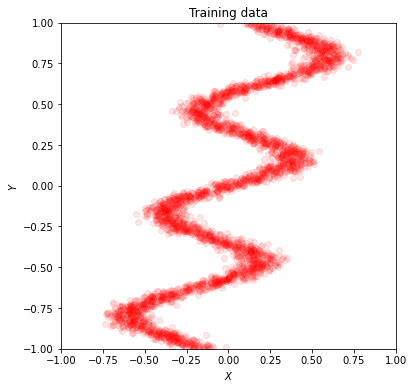

In [3]:
plt.figure(figsize=(6, 6))
plt.plot(X, Y, 'ro', alpha=0.1)
plt.xlabel(r'$X$'); plt.ylabel(r'$Y$')
plt.title('Training data')
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
plt.show()

Note that this is a form of ill-posed inverse problem in that $Y|X$ has a multimodal distribution for many values of $X$. Standard mean-squared-error regression will fail for this example -- we need full conditional density estimation.

Now we will build a mixture density network.

In [4]:
from dn import Gm  # Import custom Gaussian mixture object.

# Data parameters
BATCH_SIZE = 32                         # Size of minibatches for optimisation algorithm
I_SIZE = 1                              # Dimension of X
O_SIZE = 1                              # Dimension of Y

# Network hyperparameters
N_C = 24                                # Number of mixture components
N_HL = 6                                # Number of hidden layers
N_HU = [256] * N_HL                     # Numbers of units in hidden layers
HL_ACTIVATION = 'relu'                  # Activation on hidden layer units
HL_REGULARISER = None                   # Hidden layer regularisation

# Initialise Gaussian mixture "layer"
gm = Gm(o_size=O_SIZE, n_c=N_C, scale_type='tril')

def build_nn():
    """ Initialise neural network. """
    # Create input layer.
    l_i = tf.keras.layers.Input(shape=(I_SIZE), name='input_layer',
                                batch_size=BATCH_SIZE)

    # Make hidden layers.
    h_layers = []
    for hl_i in range(len(N_HU)):
        if hl_i == 0:
            h_layers.append(tf.keras.layers.Dense(
                N_HU[hl_i], activation=HL_ACTIVATION,
                kernel_regularizer=HL_REGULARISER,
                name='hidden_layer_{}'.format(hl_i))(l_i))
        else:
            h_layers.append(tf.keras.layers.Dense(
                N_HU[hl_i], activation=HL_ACTIVATION,
                kernel_regularizer=HL_REGULARISER,
                name='hidden_layer_{}'.format(hl_i))(h_layers[-1]))
    # Make output layer.
    l_o = tf.keras.layers.Dense(gm.params_size, use_bias=False,
                                name='params_layer')(h_layers[-1])

    # Construct model
    neural_net = tf.keras.models.Model(l_i, l_o)
    return neural_net

NN = build_nn()

2022-06-29 20:35:17.850869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next we will train the model. The loss function we use is the negative log likelihood, so that our optimisation procedure is seeking maximum likelihood estimates for the parameters. We use half of the data for training and half for validation.

In [5]:
# Training parameters
LOSS = gm.nll_reg
METRICS = None
LEARNING_RATE = 5e-4
OPTIMISER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
EPOCHS = 200

# Compile and train model
NN.compile(loss=LOSS, optimizer=OPTIMISER, metrics=METRICS)
History = NN.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE,
                 validation_split=0.5, verbose=2)

Epoch 1/200
50/50 - 3s - loss: 20.8073 - val_loss: 15.2275 - 3s/epoch - 60ms/step
Epoch 2/200
50/50 - 1s - loss: 14.2369 - val_loss: 13.7770 - 645ms/epoch - 13ms/step
Epoch 3/200
50/50 - 1s - loss: 13.7450 - val_loss: 12.5566 - 636ms/epoch - 13ms/step
Epoch 4/200
50/50 - 1s - loss: 12.9519 - val_loss: 12.9175 - 686ms/epoch - 14ms/step
Epoch 5/200
50/50 - 1s - loss: 13.2610 - val_loss: 13.0125 - 752ms/epoch - 15ms/step
Epoch 6/200
50/50 - 1s - loss: 12.6956 - val_loss: 13.6301 - 729ms/epoch - 15ms/step
Epoch 7/200
50/50 - 1s - loss: 13.7820 - val_loss: 12.2210 - 653ms/epoch - 13ms/step
Epoch 8/200
50/50 - 1s - loss: 13.0144 - val_loss: 11.8384 - 671ms/epoch - 13ms/step
Epoch 9/200
50/50 - 1s - loss: 12.4358 - val_loss: 10.8288 - 626ms/epoch - 13ms/step
Epoch 10/200
50/50 - 1s - loss: 12.3507 - val_loss: 12.1286 - 682ms/epoch - 14ms/step
Epoch 11/200
50/50 - 1s - loss: 12.0645 - val_loss: 13.4337 - 697ms/epoch - 14ms/step
Epoch 12/200
50/50 - 1s - loss: 12.8163 - val_loss: 9.8019 - 727ms

See how training and test loss progresses during training.

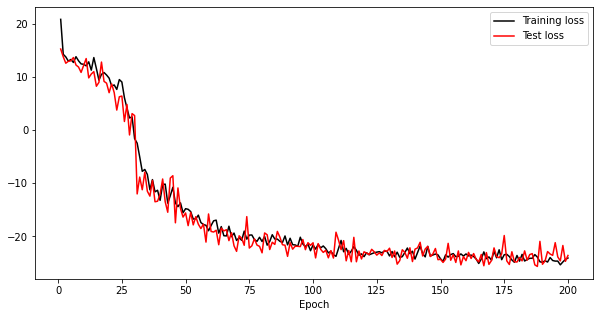

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), History.history['loss'], 'k',
         label='Training loss')
plt.plot(range(1, EPOCHS + 1), History.history['val_loss'], 'r',
         label='Test loss')
plt.xlabel('Epoch')
# plt.yscale('log')
plt.legend()
plt.show()

Since this example is low-dimensional, we can visualise the learned conditional density.

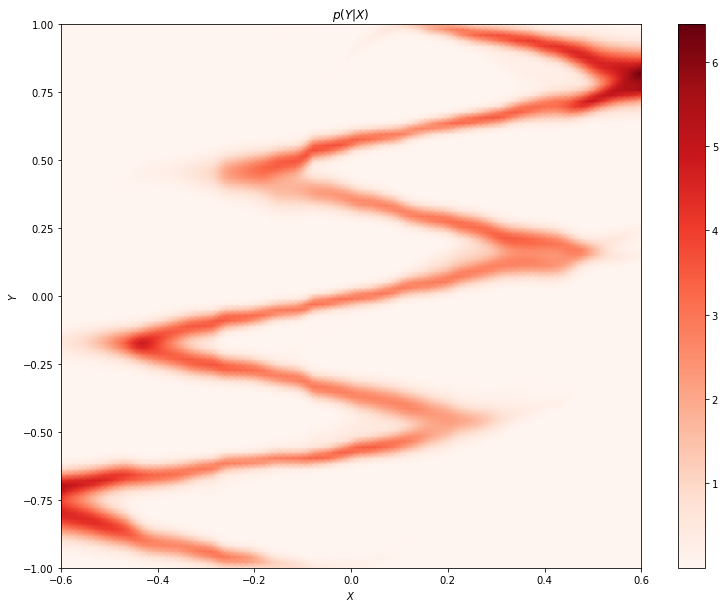

In [7]:
gm.neural_net = NN
n = 100
x = np.linspace(-0.6, 0.6, n).reshape(-1, 1)
y = np.linspace(-1., 1., n).reshape(-1, 1)
xx, yy = np.meshgrid(x, y)
pyx = gm.density(x[:, None], y[:, None]).numpy()

plt.figure(figsize=(13, 10))
plt.pcolormesh(xx, yy, pyx, cmap='Reds', shading='gouraud')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$p(Y|X)$')
plt.colorbar()
plt.show()

The form of the oscillatory function used to generate the data can be seen clearly.

We can also take a look at $p(Y|X)$ for a particular value of $X$. Below we look at $X=0$.

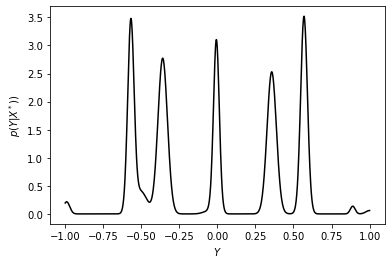

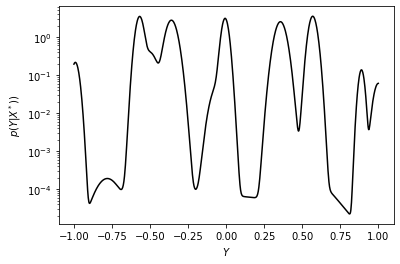

In [8]:
x_star = np.array((0.,)).reshape((1, I_SIZE))
ys = np.linspace(-1., 1., 1000).reshape((1000, O_SIZE))
pygx_star = gm.density(x_star, ys)

plt.figure(figsize=(6, 4))
plt.plot(ys, pygx_star, 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$p(Y|X^*))$')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, pygx_star, 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$p(Y|X^*))$')
plt.yscale('log')
plt.show()

We can see from the linear scale plot that the five peaks of the distribution are well identified; however, the log scale plot highlights a lot of spurious lesser peaks -- these exist because a) the model is imperfect, and b) the data used to train the model only provides a finite amount of information. We might want to employ some regularisation techniques to improve our estimation -- at the moment this is pure maximum likelihood.